Notebook created by Peder Lillebostad, slightly modified and expanded with fastai by A.S. Lundervold

# Segmenting cells automatically using U-net

In this notebook we take on the [data science bowl 2018](https://www.kaggle.com/c/data-science-bowl-2018) challenge on Kaggle. The task is straight forward: teach a neural network to segment cells from the background from a set of labelled micrographs. The basic structure of such a network needs to satisfy the criteria: the number of input neurons must match the image dimensions, and so does the output layer. Thus we essentially are classifying every pixel in the input.

<img width=40% src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png">

Read the original paper [here](https://arxiv.org/abs/1505.04597).


### Get the data
Follow the above link to download the data. We'll only use the file `stage1_train.zip`.


### Note

Much of the code in the notebook will be very detailed, and we recommend not spending too much time reviewing everything, as much is simple utiliy functions (crucial for the code to run, but not crucial for the concepts). Finally, this notebook is not made for performance, but more as a proof-of-concept, with the intention that it should be possible to run on a CPU.


The code has been modified from  https://www.kaggle.com/arunmohan003/unet-starter-pytorch.

## Setup

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# If Jedi's not working (autocomplete)
%config Completer.use_jedi = False

In [3]:
import torch

In [4]:
# set device to either CPU or GPU 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [5]:
import os, time, copy, shutil
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
from PIL import Image
from skimage import io, transform
import cv2

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torch import nn
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.nn.functional as F
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.pytorch import ToTensor

In [6]:
# Point this to where you placed the file `stage1_train.zip'
DATA = Path('/data2/DSB2018')

In [7]:
# Run once
#for f in DATA.glob('*.zip'):
#    shutil.unpack_archive(f, extract_dir=DATA)

We now have a bunch of images

In [7]:
len(list(DATA.iterdir())), list(DATA.iterdir())[:5]

(673,
 [PosixPath('/data2/DSB2018/b1e3aeb0c56261c17eb71c747d116057b8da7e8c8a6845bdc01b2b3ee2299229'),
  PosixPath('/data2/DSB2018/0e5edb072788c7b1da8829b02a49ba25668b09f7201cf2b70b111fc3b853d14f'),
  PosixPath('/data2/DSB2018/4d4f254f3b8b4408d661df3735591554b2f6587ce1952928d619b48010d55467'),
  PosixPath('/data2/DSB2018/5ba4facefc949c920d7054813a3e846b000969da2ed860148bdfd18456f59bcc'),
  PosixPath('/data2/DSB2018/61dc249314d7b965eb4561ec739eab9b0f60af55c97b25ced8cb2a42a0be128e')])

### Tensors
You're likely already familiar with numpy arrays. We now make a minor transition to (PyTorch) tensors. They still represent the same fundamental objects, but are tailored for deep learning applications. 

In [9]:
t = torch.rand(5,3)
print(type(t))
print(t)
print(t.size()) # equivalent to array.shape

<class 'torch.Tensor'>
tensor([[0.4900, 0.0309, 0.7349],
        [0.1874, 0.5782, 0.6951],
        [0.5642, 0.3735, 0.0701],
        [0.6990, 0.4071, 0.1840],
        [0.4401, 0.8720, 0.1860]])
torch.Size([5, 3])


## Datasets in Pytorch

When we train neural networks we often make use of very large datasets. Loading all the data into memory simultaneously is an a waste of resources. Datasets in Pytorch are special classes which contains the path to the data as well as functions for loading the data into memory on demand. Here is a custom made class for this particular dataset. The key method we implement is `__getitem__`, which does everything to load a single sample.


### Data augmentation

We will also implement a simple yet powerful trick: we can artificially increase the dataset by creating new samples from old ones through applying minor transformations (flipping, rotating etc) which still retain the crucial features important for classification. This will be built into the dataset class itself.


In [10]:
def get_transforms(mean, std):
            list_transforms = []
            list_transforms.extend([HorizontalFlip(p=0.5)])
            list_transforms.extend([Normalize(mean=mean, std=std, p=1),
            ToTensor()])
            list_trfms = Compose(list_transforms)
            return list_trfms


class NucleiData(Dataset):
        def __init__(self,path):
            self.path = path
            self.folders = [f for f in os.listdir(path) if 'stage' not in f]
            self.transforms = get_transforms(0.5, 0.5)
        
        def __len__(self):
            return len(self.folders)
            
        def __getitem__(self,idx):
            image_folder = os.path.join(self.path,self.folders[idx],'images/')
            mask_folder = os.path.join(self.path,self.folders[idx],'masks/')
            image_path = os.path.join(image_folder,os.listdir(image_folder)[0])
            
            img = io.imread(image_path)[:,:,:3].astype('float32')
            mask = self.get_mask(mask_folder, img.shape[0], img.shape[1]).astype('float32')
            
            # Apply transformations
            augmented = self.transforms(image=img, mask=mask) #returns a dict
            img = augmented['image']
            mask = augmented['mask']
            mask = mask[0].permute(2, 0, 1) # just reorders the dimensions of the tensor
            return (img,mask) 


        def get_mask(self,mask_folder, IMG_HEIGHT, IMG_WIDTH):
            mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
            for mask_ in os.listdir(mask_folder):
                    mask_ = io.imread(os.path.join(mask_folder,mask_))
                    mask_ = np.expand_dims(mask_,axis=-1)
                    mask = np.maximum(mask, mask_)
            return mask

In [11]:
data = NucleiData(DATA)

In [20]:
DATA

PosixPath('/data2/DSB2018')

#### Exercise 1. Figure out the dimensions of the first few samples.

In [12]:
# %load solutions/ex7_1.py

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 320])
torch.Size([3, 360, 360])
torch.Size([3, 520, 696])
torch.Size([3, 256, 320])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 360, 360])
torch.Size([3, 256, 320])


You will see they differ in size. This is a problem, because the number of input pixels must match the number of neurons in the first layer of the neural network. 

#### Exercise 2. Edit the above class to resize all images to width and height of 128 pixels.

In [8]:
# %load solutions/ex7_2.py

In [14]:
# print out some sample data
print(data.__len__())
data.__getitem__(0)[1]

670


tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0020, 0.0010, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])

In [15]:
for img,msk in data:
    print(img.shape)
    print(msk.shape)
    break

torch.Size([3, 64, 64])
torch.Size([1, 64, 64])


### Train-test split
Again we must determine the split prior to loading the data. 

In [16]:
n_tot = len(data)
n_train = int(.85*n_tot) # 85% for training 
n_val = n_tot - n_train
trainset, valset = random_split(data, [n_train, n_val])

### Dataloaders in Pytorch
The Dataloader class in Pytorch is essentially like the Dataset, but with some additional functionality.

In [17]:
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=valset, batch_size=8, shuffle=False)

In [18]:
# some utility functions, you can ignore these
def mask_convert(mask):
    mask = mask.clone().cpu().detach().numpy()
    mask = mask.transpose((1,2,0))
    std = np.array((0.5))
    mean = np.array((0.5))
    mask  = std * mask + mean
    mask = mask.clip(0,1)
    mask = np.squeeze(mask)
    return mask

# converting tensor to image
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    std = np.array((0.5,0.5,0.5))
    mean = np.array((0.5,0.5,0.5))
    image  = std * image + mean
    image = image.clip(0,1)
    image = (image * 255).astype(np.uint8)
    return image

def plot_img(no_):
    iter_ = iter(train_loader)
    images,masks = next(iter_)
    images = images.to(device)
    masks = masks.to(device)
    plt.figure(figsize=(10,6))
    for idx in range(0,no_):
        image = image_convert(images[idx])
        plt.subplot(2,no_,idx+1)
        plt.title('image')
        plt.imshow(image)
    for idx in range(0,no_):
        mask = mask_convert(masks[idx])
        plt.subplot(2,no_,idx+no_+1)
        plt.title('mask')
        plt.imshow(mask,cmap='gray')
    plt.show()

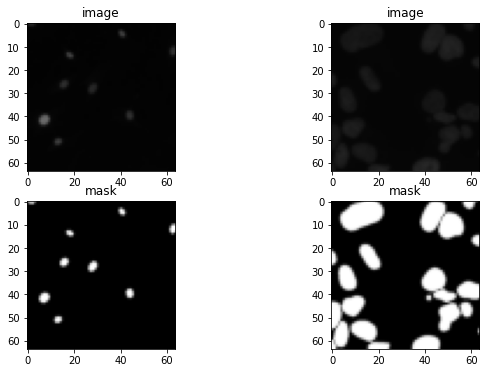

In [19]:
# we will try visualizing images and corresponding masks
plot_img(2)

## Building the neural network

In Pytorch, we implement models as a class, inheriting from `nn.Module`, which provides a set of standardized behind-the-scenes methods. Crucial when defining a custom network is to implement a `forward` method which represents the forward pass of the input.

The U-Net consists of a sequence of convolutional layers (down-sampling), followed by a symmetrical sequence of upsampling layers. Importantly there is a connection between corresponding layers in the down-sampling and up-sampling layers (skip connections), so it deviates from a canonical feed-forward network in this regard. The skip connection is implemented simply by concatenating the activations of an intermediate layer with the activations from the layer in the skip connection. 

In [21]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

class Unet(nn.Module):
    def __init__(self):
        super().__init__()
        self.dblock1 = double_conv(3, 64)
        self.dblock2 = double_conv(64, 128)
        self.dblock3 = double_conv(128,256)
        self.dblock4 = double_conv(256,512)

        self.pool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) 

        self.dblock5 = double_conv(256 + 512, 256)
        self.dblock6 = double_conv(128 + 256, 128)
        self.dblock7 = double_conv(128 + 64, 64)

        self.last_layer = nn.Conv2d(64,1,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        # down-sampling
        conv1 = self.dblock1(x)
        x = self.pool(conv1)
        conv2 = self.dblock2(x)
        x = self.pool(conv2)
        conv3 = self.dblock3(x)
        x = self.pool(conv3)
        conv4 = self.dblock4(x)
        
        # up-samling
        x = self.upsample(conv4)
        x = torch.cat([x, conv3], dim=1) # skip connection
        x = self.dblock5(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1) # skip connection
        x = self.dblock6(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1) # skip connection
        x = self.dblock7(x)

        out = self.last_layer(x)
        return out

In [22]:
# loading the model to the GPU (or CPU)
model = Unet().to(device)
model

Unet(
  (dblock1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dblock2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dblock3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dblock4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2,


### Loss function and IOU metric

This loss combines Dice loss with the standard binary cross-entropy (BCE) loss that is generally the default for segmentation models. Combined the two methods allows for some diversity in the loss, while benefitting from the stability of BCE.Similarly we use intersection over union as a metric


In [23]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        bce_weight = 0.5
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        loss_final = BCE * bce_weight + dice_loss * (1 - bce_weight)
        return loss_final
    
## IOU computation
def iou_(y_pred,y):
    inputs = y_pred.reshape(-1)
    targets = y.reshape(-1)
    intersection = (inputs * targets).sum()
    total = (inputs + targets).sum()
    union = total - intersection 
    smooth = 1    
    iou = (intersection + smooth)/(union + smooth)
    return iou


def iou_batch(y_pred,y):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    y_pred = torch.sigmoid(y_pred)
    y_pred = y_pred.clone().cpu().detach().numpy()
    y = y.clone().cpu().detach().numpy() 
    
    for pred, label in zip(y_pred, y):
        ious.append(iou_(pred, label))
    iou = np.nanmean(ious)
    return iou 

## Preparing for training

The algorithm for updating the network weights must be specified also. First we need to specify how to compute the loss function (here called criterion). The strategy of updating the gradients is defined in the optimizer (you have multiple choices from `torch.optim`.

In [24]:
model = Unet().to(device)

In [25]:
# decide upon a number of epochs before running
epochs = 4

criterion = DiceBCELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#valid_loss_min = 3.95275

# A training loop for the network

Note: training a neural network is usually a very slow process, so the cell below will take some time to run.

In [26]:
# We wish to record the performance along the way for each epoch
train_loss,val_loss = [],[]
train_iou,val_iou = [],[]

for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch + 1, epochs))
    start_time = time.time()
         
    running_train_loss = []
    running_train_score = []
    for image,mask in train_loader: 
        print('|',end='') #primitive loading bar, each bar representing a batch

        image = image.to(device,dtype=torch.float)
        mask = mask.to(device,dtype=torch.float)
        
        pred_mask = model.forward(image) # forward propogation
        loss = criterion(pred_mask,mask) # compute the loss
        score = iou_batch(pred_mask,mask)
        
        # Do the weight updating
        optimizer.zero_grad() # setting gradient to zero
        loss.backward() # compute the gradients
        optimizer.step() # update the weights based on the gradients 
        
        # Record results
        running_train_loss.append(loss.item())
        running_train_score.append(score)

    else:           
        running_val_loss = []
        running_val_score = []
        with torch.no_grad():
            for image,mask in val_loader:
                    image = image.to(device,dtype=torch.float)
                    mask = mask.to(device,dtype=torch.float)                            
                    pred_mask = model.forward(image)
                    loss = criterion(pred_mask,mask)
                    score = iou_batch(pred_mask,mask)
                    running_val_loss.append(loss.item())
                    running_val_score.append(score)

                                    
    epoch_train_loss,epoch_train_score = np.mean(running_train_loss) ,np.mean(running_train_score)
    print('\nTrain loss : {} iou : {}'.format(epoch_train_loss,epoch_train_score))                       
    train_loss.append(epoch_train_loss)
    train_iou.append(epoch_train_score)
    
    epoch_val_loss,epoch_val_score = np.mean(running_val_loss),np.mean(running_val_score)
    print('Validation loss : {} iou : {}'.format(epoch_val_loss,epoch_val_score))                                
    val_loss.append(epoch_val_loss)
    val_iou.append(epoch_val_score)
    

    time_elapsed = time.time() - start_time
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Epoch 1/4
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Train loss : 0.5990063266621696 iou : 0.11144303329055999
Validation loss : 0.5220397756649897 iou : 0.14767317809332667
4m 48s
Epoch 2/4
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Train loss : 0.46290788675347966 iou : 0.22888588836569415
Validation loss : 0.5531152922373551 iou : 0.2526032580032154
4m 48s
Epoch 3/4
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Train loss : 0.3736032413111793 iou : 0.3433214781351372
Validation loss : 0.33387159613462597 iou : 0.4594680769658546
4m 47s
Epoch 4/4
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Train loss : 0.295978679218226 iou : 0.447264675708347
Validation loss : 0.24333986639976501 iou : 0.514050150029249
4m 47s


In [27]:
train_loss

[0.5990063266621696,
 0.46290788675347966,
 0.3736032413111793,
 0.295978679218226]

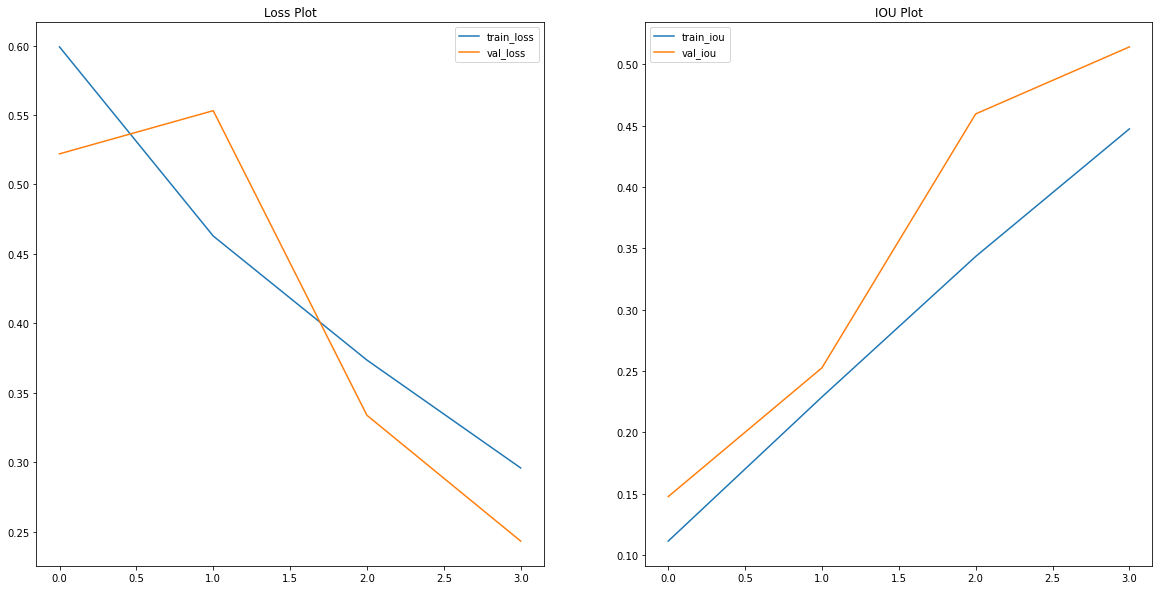

In [29]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(train_loss,label='train_loss')
plt.plot(val_loss,label='val_loss')
plt.legend()
plt.title('Loss Plot')
plt.subplot(1,2,2)
plt.plot(train_iou,label='train_iou')
plt.plot(val_iou,label='val_iou')
plt.legend()
plt.title('IOU Plot')
plt.show()

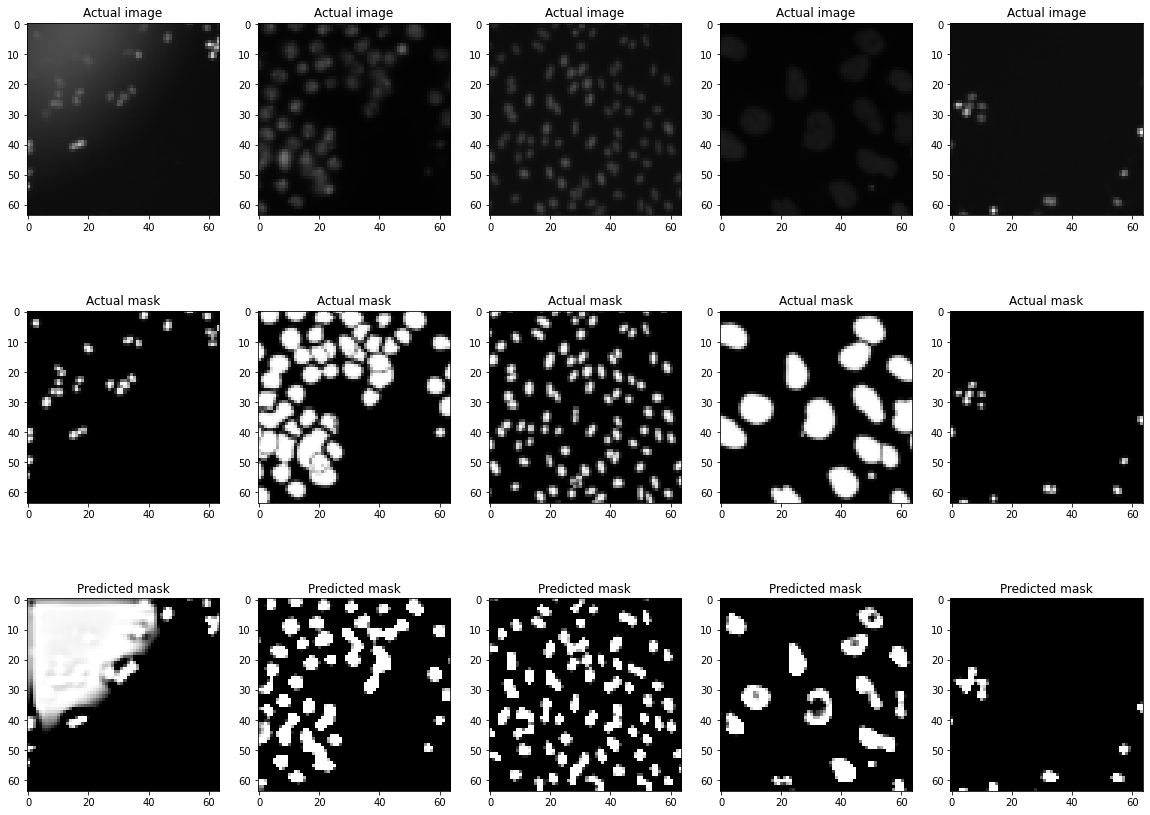

In [34]:
iter_ = iter(val_loader)
image,mask = next(iter_)
image = image.to(device,dtype=torch.float)
mask = mask.to(device,dtype=torch.float)
y_pred = model.forward(image)


plt.figure(figsize=(20,15))
for i in range(0,5):
    plt.subplot(3,5,i+1)
    plt.title('Actual image')
    plt.imshow(image_convert(image[i]))
for i in range(0,5):
    plt.subplot(3,5,i+5+1)
    plt.title('Actual mask')
    plt.imshow(mask_convert(mask[i]),cmap='gray')
for i in range(0,5):
    plt.subplot(3,5,i+10+1)
    plt.title('Predicted mask')
    plt.imshow(mask_convert(y_pred[i]),cmap='gray')
plt.show()

# Using fastai and a Dynamic UNet

We've had some experience using fastai for image analysis tasks. Let's try it out for segmentation:

In [7]:
from fastai.vision.all import *

In [8]:
DATA

Path('/data2/DSB2018')

In [11]:
img_folders = [f for f in DATA.glob('*') if 'stage' not in str(f)]
len(img_folders)

672

We'll convert all the masks to single binary masks and save them once and for all (saves time during model training):

In [12]:
# We use the above `get_image` function to create and save images
def save_imgs(img_folder):
    masks = glob.glob(str(img_folder) + '/masks/*')
    img_fn = Path(glob.glob(str(img_folder) + '/images/*')[0])
    img = load_image(img_fn)
    IMG_HEIGHT, IMG_WIDTH = img.shape
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    for mask_ in masks:
        mask_ = load_image(mask_)
        mask_ = np.expand_dims(mask_,axis=-1)
        mask = np.maximum(mask, mask_)
        
    # Save
    mask = Image.fromarray(mask[:,:,0])
    mask.save(img_folder/'..'/'masks'/f'{img_fn.stem}-binary_mask.png')
    img.save(img_folder/'..'/'images'/f'{img_fn.stem}.png')
    return mask

In [92]:
# Run this once
#for img_folder in img_folders:
#    save_imgs(img_folder)

In [13]:
images = get_files(DATA/'images', extensions='.png')
len(images)

670

In [15]:
sz = 200

In [16]:
# Modified from fastai's MaskBlock to divide the masks by 255 (to make them 0/1)
def MaskBlock(codes=None):
    "A `TransformBlock` for segmentation masks, potentially with `codes`"
    return TransformBlock(type_tfms=PILMask.create, item_tfms=AddMaskCodes(codes=codes), batch_tfms=IntToFloatTensor(div_mask=255))

In [17]:
get_y = lambda o: DATA/'masks'/(o.stem+'-binary_mask.png')

In [18]:
db = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=['fg', 'bg'])),
    splitter=RandomSplitter(),
    get_items=get_image_files,
    get_y=get_y,
    item_tfms=Resize(224),
    batch_tfms=[Normalize.from_stats(*imagenet_stats)])

In [19]:
dls = db.dataloaders((DATA/'images'), bs=8)

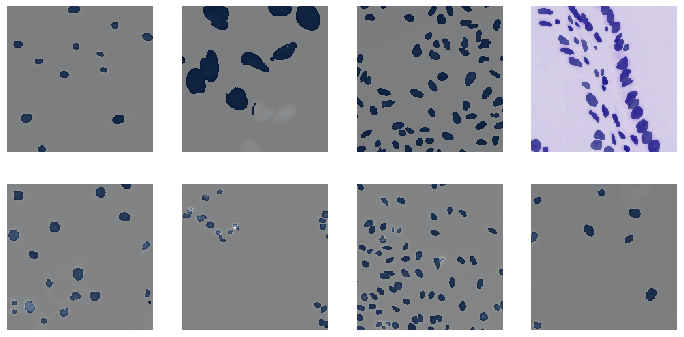

In [20]:
dls.show_batch(cmap='Blues', vmin=0, vmax=1)

In the UNet model there is a downward path (encoder) and an upward path (decoder). The downward part of the model is essentially a standard image classification model, so why not use a _pretrained_ image classification model? This trick is implemented by fastai in what they call a _Dynamic UNet_ https://docs.fast.ai/vision.models.unet. 

<img width=40% src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png">

In [21]:
learn = unet_learner(dls, resnet34, metrics=[Dice()])

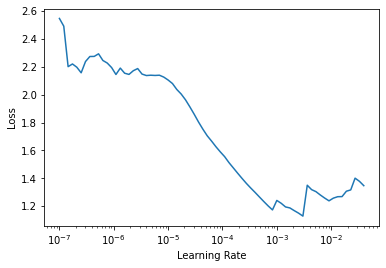

In [22]:
lr_min, _ = learn.lr_find()

In [23]:
learn.fit_one_cycle(5, slice(lr_min))

epoch,train_loss,valid_loss,dice,time
0,0.356476,0.116438,0.821434,00:08
1,0.165889,0.162165,0.806774,00:08
2,0.099932,0.082711,0.886965,00:08
3,0.080476,0.079983,0.890413,00:08
4,0.071495,0.075678,0.895159,00:08


Here are some targets and predictions:

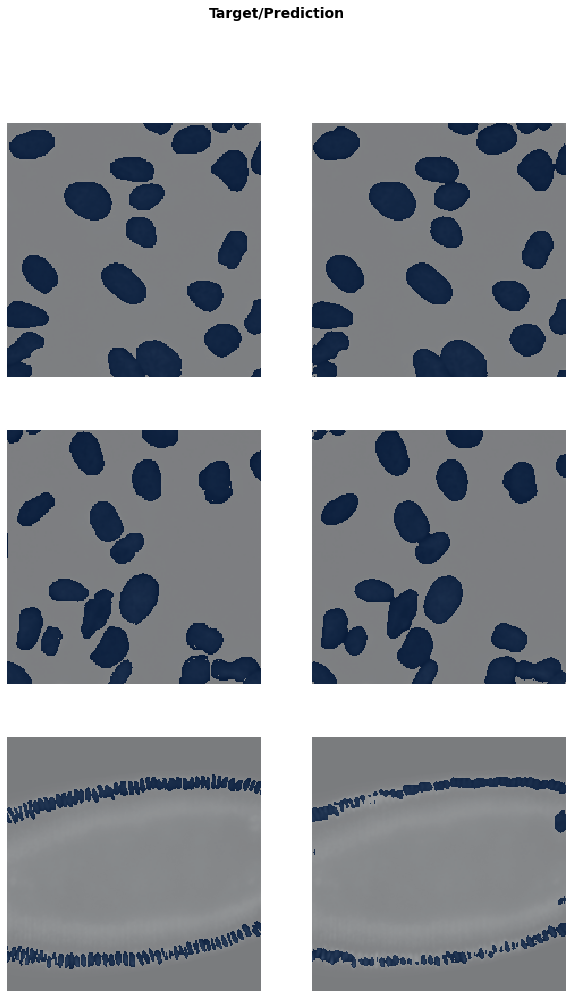

In [24]:
learn.show_results(cmap='Blues', vmin=0, vmax=1, max_n=3, figsize=(10,16))

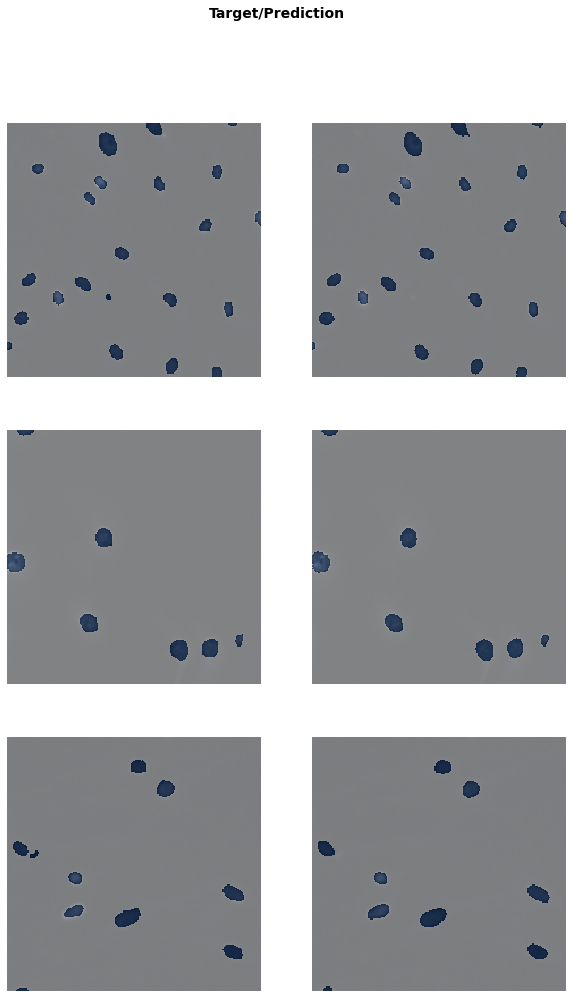

In [25]:
learn.show_results(cmap='Blues', vmin=0, vmax=1, max_n=3, figsize=(10,16))

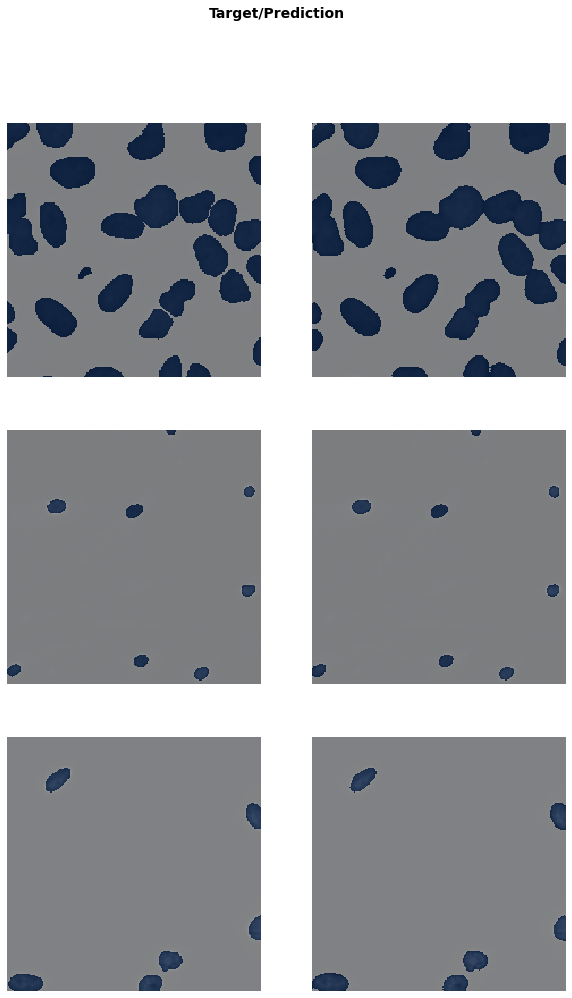

In [30]:
learn.show_results(cmap='Blues', vmin=0, vmax=1, max_n=3, figsize=(10,16))